In [57]:
import numpy as np
import pandas as pd
from statistics import mean, stdev

import pyro
import pyro.distributions as dist
import pyro.poutine as poutine
from pyro.infer import SVI, Trace_ELBO, TraceMeanField_ELBO,TraceGraph_ELBO, MCMC, NUTS, HMC
from pyro.poutine.runtime import effectful

import torch
from torch.distributions import constraints

import matplotlib.pyplot as plt
import seaborn as sns
import time 

from scipy import stats
import graphviz
from tqdm import tqdm

import yaml



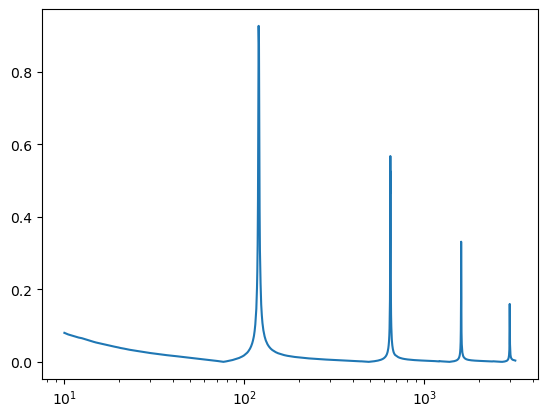

In [58]:
experiment = pd.read_csv("../Data/bend/centerFreqResponse.csv")[20:]
# Mobility value calculated from input data and converted to torch
mobility = abs(experiment["force"].values + 1j*experiment["velocity"].values)
freq = experiment["freq"].values
plt.plot(freq, mobility)
plt.xscale("log")

In [179]:
goalFreq

array([ 117.5,  118. ,  118.5,  119. ,  119.5,  121. ,  121.5,  122. ,
        122.5,  123. ,  644.5,  645. ,  645.5,  646. ,  646.5,  647. ,
        647.5,  648. ,  648.5,  649. ,  649.5,  650. ,  650.5,  651. ,
       1599.5, 1600. , 1600.5, 1601. , 1601.5, 1602. , 1602.5, 1603. ])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0.009756027946305146
0.03392326311944704


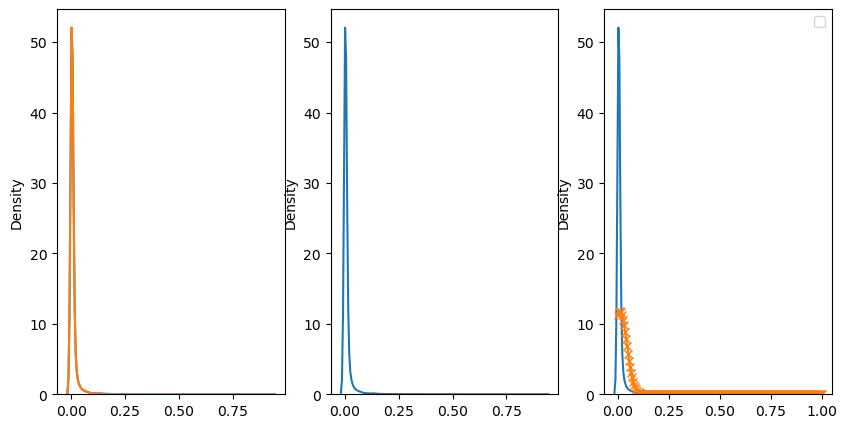

In [59]:
fig, axes = plt.subplots(figsize=(10,5), ncols=3, nrows=1)
goal = mobility#[np.logical_and(mobility>0.2, mobility<0.75)]
goalFreq = freq#[np.logical_and(mobility>0.2, mobility<0.75)]
sns.kdeplot(mobility, label="mobility all values", ax=axes[0])
sns.kdeplot(goal, label="mobility > 0.2", ax=axes[0])
sns.kdeplot(mobility, ax=axes[1])
meanDist = mean(goal)
stdDist = stdev(goal)
print(meanDist)
print(stdDist)
x = np.linspace(0, 1, 200)
sns.kdeplot(goal, ax=axes[2])
axes[2].plot(x, stats.norm.pdf(x, meanDist, stdDist), "x-")
plt.legend()

In [60]:
stats.beta.fit(goal)

/opt/miniconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:684: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/opt/miniconda3/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


(0.5584855477302662,
 404.46112818774407,
 6.523215753790456e-06,
 7.290167872217724)

Text(1000, 0.65, 'number of points: 6381')

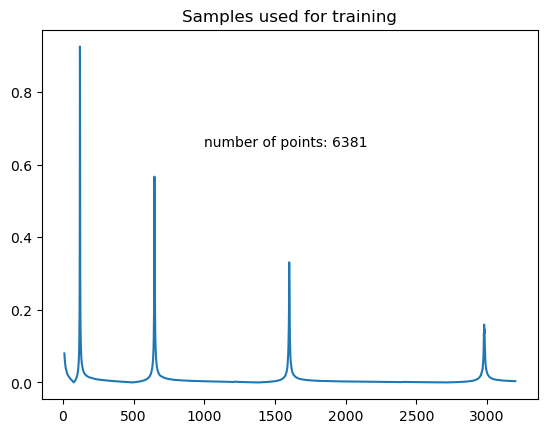

In [61]:
plt.plot(goalFreq, goal)
plt.title("Samples used for training")
plt.text(1000, 0.65,"number of points: "+str(len(goal)))

In [62]:
E_values = []
rho_values = []
eta_values = []

def normalization(rho, eta, E):
    E_theo=9.7e10
    E_var_init = 5e9
    rho_theo=8000.0
    rho_var_init = 250
    eta_mean=0.00505
    eta_var_init = 0.006
    
    rho_norm = rho*0.1*rho_var_init + rho_theo
    eta_norm = eta*0.1*eta_var_init + eta_mean
    E_norm = E*0.1*E_var_init + E_theo

    return rho_norm, eta_norm, E_norm

def model(x, y_obs):
    # Density definition
    rho_mean = pyro.param("rho_mean", torch.tensor(0.))
    rho_std = pyro.param("rho_std", torch.tensor(.1), constraint=constraints.positive)
    rho = pyro.sample("rho", dist.Normal(rho_mean, rho_std))
    # Damping loss factor definition
    eta_mean = pyro.param("eta_mean", torch.tensor(0.))
    eta_std = pyro.param("eta_std", torch.tensor(.1), constraint=constraints.positive)
    eta = pyro.sample("eta", dist.Normal(eta_mean, eta_std))
    # Young's modulus definition
    E_mean = pyro.param("E_mean", torch.tensor(0.))
    E_std = pyro.param("E_std", torch.tensor(.1), constraint=constraints.positive)
    E = pyro.sample("E", dist.Normal(E_mean, E_std))
    
    rho, eta, E = normalization(rho, eta, E)
    #rho, eta, E = normalization(rho*rho_std+rho_mean, eta*eta_std+eta_mean, E*E_std+E_mean)
    E_values.append(E)
    rho_values.append(rho)
    eta_values.append(eta)

    y_values = mobilityFuncModel(E, rho, eta, x)
    with pyro.plate("data", len(y_obs)):
        y = pyro.sample("y", dist.Normal(y_values, 0.13), obs=y_obs)
        #y = pyro.sample("y", dist.Beta(paramsBeta[0], paramsBeta[1]), obs=y_obs)
    return y

def guide(x, y_obs):
    # Density guide
    rho_mean_q = pyro.param("rho_mean_guide", torch.tensor(0.))
    rho_std_q = pyro.param("rho_std_guide", torch.tensor(0.001), constraint=constraints.positive)
    pyro.sample("rho", dist.Normal(rho_mean_q, rho_std_q))
    # Damping loss factor guide
    eta_mean_q = pyro.param("eta_mean_guide", torch.tensor(0.))
    eta_std_q = pyro.param("eta_std_guide", torch.tensor(0.001), constraint=constraints.positive)
    pyro.sample("eta", dist.Normal(eta_mean_q, eta_std_q))

    # Damping loss factor guide
    E_mean_q = pyro.param("E_mean_guide", torch.tensor(0.))
    E_std_q = pyro.param("E_std_guide", torch.tensor(0.001), constraint=constraints.positive)
    pyro.sample("E", dist.Normal(E_mean_q, E_std_q))

def mobilityFuncModel(E_dist, rho_dist, eta_dist, freq, E_theo=10e10, rho_theo=8976, eta_theo=0.007):
    """
    Calculates the mobility value based on the Young's modulus(E) and the frequency
    Input: 
        E   : Young's modulus
        eta : loss factor
    Output: 
        Y   : Mobility value
    """
    beam = {"length": 0.301,
        "width": 0.026,
        "thickness": 0.003,
        
        "E": 10e10,
        
        "mass": 0.1877,
        
        }
    beam["massPerUnit"] = beam["mass"] / beam["length"]
    beam["volume"] = beam["length"] * beam["width"] * beam["thickness"]
    beam["I"] = beam["width"]*beam["thickness"]**3/12

    E = E_dist
    rho = rho_dist
    eta = eta_dist
    l = beam["length"]/2

    # calculating the bending wave number
    w = 2*torch.pi*freq # Angular frequency
    B = E*beam["I"] #
    complex_B = E*(1+1j*eta)*beam["I"]
    massPerUnit = rho*beam["thickness"]*beam["width"]
    cb = torch.sqrt(w)*(B/massPerUnit)**(1/4) # bending wave velocity
    
    kl = w/(cb)*l # bending wave number
    complex_kl = kl*(1-1j*eta/4)
    N_l = torch.cos(complex_kl)*torch.cosh(complex_kl) + 1
    D_l = torch.cos(complex_kl)*torch.sinh(complex_kl) + torch.sin(complex_kl)*torch.cosh(complex_kl)

    Y = -(1j*l)/ (2*complex_kl*torch.sqrt(complex_B *massPerUnit)) * N_l/D_l
    return abs(Y)


def mobilityFuncModelNumpy(E_dist, rho_dist, eta_dist, freq):
    """
    Calculates the mobility value based on the Young's modulus(E) and the frequency
    Input: 
        E   : Young's modulus
        eta : loss factor
    Output: 
        Y   : Mobility value
    """
    beam = {"length": 0.301,
        "width": 0.026,
        "thickness": 0.003,
        
        "E": 10e10,
        
        "mass": 0.1877,
        
        }
    beam["massPerUnit"] = beam["mass"] / beam["length"]
    beam["volume"] = beam["length"] * beam["width"] * beam["thickness"]
    beam["I"] = beam["width"]*beam["thickness"]**3/12

    E = E_dist
    rho = rho_dist
    eta = eta_dist
    l = beam["length"]/2

    # calculating the bending wave number
    w = 2*np.pi*freq # Angular frequency
    B = E*beam["I"] #
    complex_B = E*(1+1j*eta)*beam["I"]
    massPerUnit = rho*beam["thickness"]*beam["width"]
    cb = np.sqrt(w)*(B/massPerUnit)**(1/4) # bending wave velocity
    
    kl = w/(cb)*l # bending wave number
    complex_kl = kl*(1-1j*eta/4)
    N_l = np.cos(complex_kl)*np.cosh(complex_kl) + 1
    D_l = np.cos(complex_kl)*np.sinh(complex_kl) + np.sin(complex_kl)*np.cosh(complex_kl)

    Y = -(1j*l)/ (2*complex_kl*np.sqrt(complex_B *massPerUnit)) * N_l/D_l
    return abs(Y)


In [65]:
freqTrain = torch.tensor(goalFreq)
data = torch.tensor(goal)

pyro.clear_param_store()
adam_params = {
    "lr": .01, #0.001,
    "betas": (0.96, 0.999),
    "clip_norm": 20.0,
    "lrd": 0.99996,
    "weight_decay": 2.0}
optim = pyro.optim.ClippedAdam(adam_params)
svi = SVI(model, guide, optim, loss=TraceGraph_ELBO())

n_steps = 500
losses = np.zeros(n_steps)
start = time.time()
for step in tqdm(range(n_steps)):   
    loss = svi.step(freqTrain, data)
    losses[step] = (loss)
totalTime = time.time() - start

100%|██████████| 500/500 [00:01<00:00, 294.80it/s]


1.6980328559875488


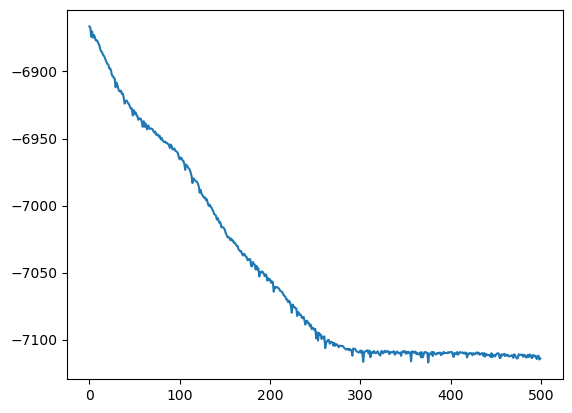

In [66]:
plt.plot(losses)
print(totalTime)

In [69]:

E_est = pyro.param("E_mean_guide").item()
eta_est = pyro.param("eta_mean_guide").item()
rho_est = pyro.param("rho_mean_guide").item()
E_std = pyro.param("E_std_guide").item()
eta_std = pyro.param("eta_std_guide").item()
rho_std = pyro.param("rho_std_guide").item()       
print(E_est)  
print(E_std)
rho, eta, E = normalization(rho_est, eta_est, E_est)
y_est = mobilityFuncModel(torch.tensor(E), torch.tensor(rho), torch.tensor(eta), torch.tensor(goalFreq))
y_total = mobilityFuncModel(torch.tensor(E), torch.tensor(rho), torch.tensor(eta), torch.tensor(freq))
y_init = mobilityFuncModel(torch.tensor(9.7e10), torch.tensor(8000.0), torch.tensor(0.00505), torch.tensor(freq))

y_total = mobilityFuncModelNumpy(E, rho, eta, freq)        
print(np.sum((mobility-y_total)**2))

2.9280905723571777
0.06622803956270218


TypeError: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'

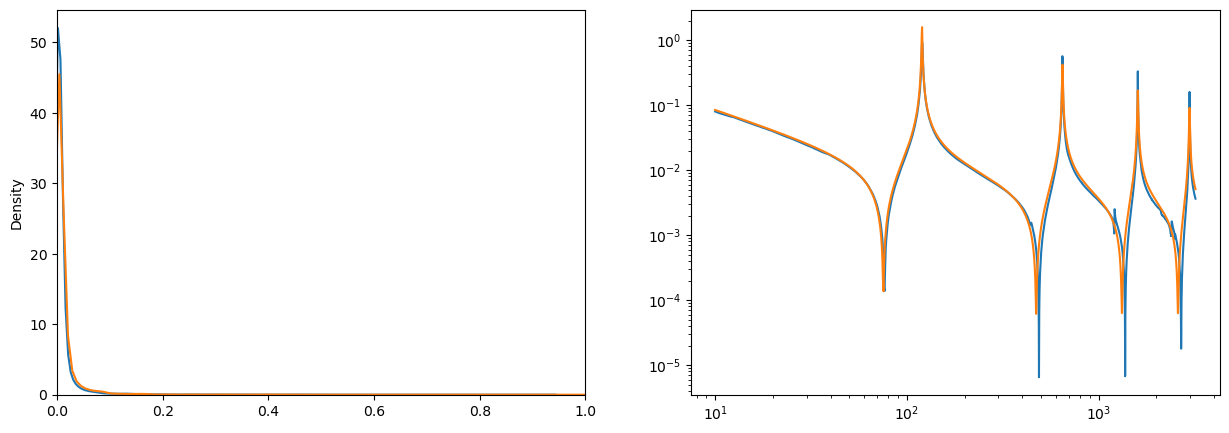

In [68]:
fig, axes = plt.subplots(figsize=(15,5), ncols=2, nrows=1)
sns.kdeplot(goal, ax=axes[0], label="True posterior")
sns.kdeplot(y_est, ax=axes[0], label="estimated posterior")
axes[0].set_xlim([0,1])
axes[1].plot(freq, mobility)
axes[1].plot(freq, y_total)
axes[1].set_xscale("log")
axes[1].set_yscale("log")

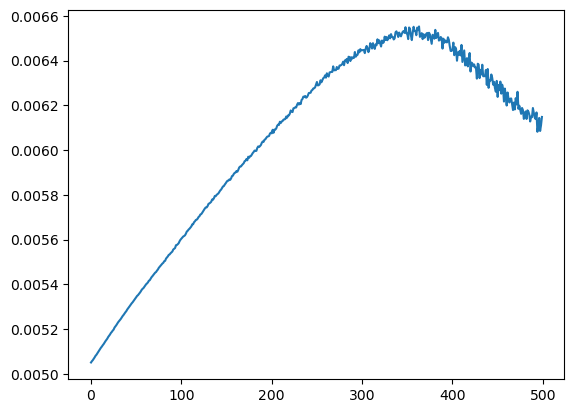

In [184]:
E_val = np.zeros(len(E_values))
eta_val = np.zeros(len(eta_values))
for i in range(len(E_values)):
    E_val[i] = E_values[i].detach().numpy()
    eta_val[i] = eta_values[i].detach().numpy()
plt.plot(eta_val)

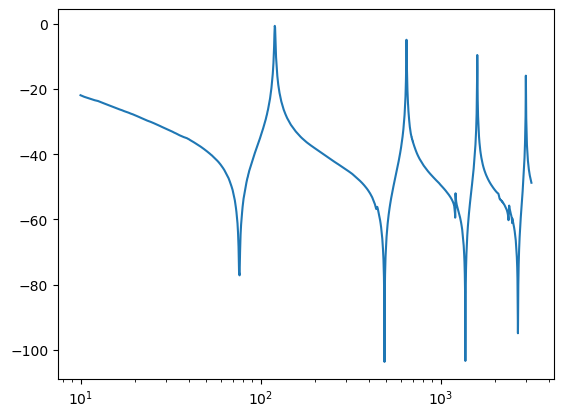

In [51]:
experiment = pd.read_csv("../Data/bend/centerFreqResponse.csv")[20:]
# Mobility value calculated from input data and converted to torch
freqmobility = 20*np.log10(abs(experiment["force"].values + 1j*experiment["velocity"].values))
freq = experiment["freq"].values
plt.plot(freq, mobility)
plt.xscale("log")

[ 220 1274 3181 5939  957 2729 5365]
357


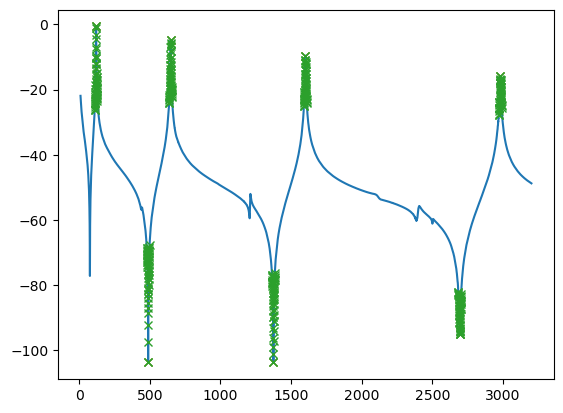

In [56]:
from scipy.signal import find_peaks

peaks1, _ = find_peaks(mobility, distance=1000) 
peaks2, _ = find_peaks(mobility*(-1), distance=1700)
peaks = np.concatenate((peaks1, peaks2))
plt.plot(freq, mobility)
peaks = peaks[[0, 1, 2, 4, 5, 6,7]]
print(peaks)
plt.plot(freq[peaks], mobility[peaks], "x")

res = np.linspace(peaks-np.ones(len(peaks))*20, peaks+np.ones(len(peaks))*20, 51).T
res = res.flatten().astype(int)
plt.plot(freq[res], mobility[res], "x")
print(len(res))

[ 220 1274 1277 2404 3181 4796 4988 5939]


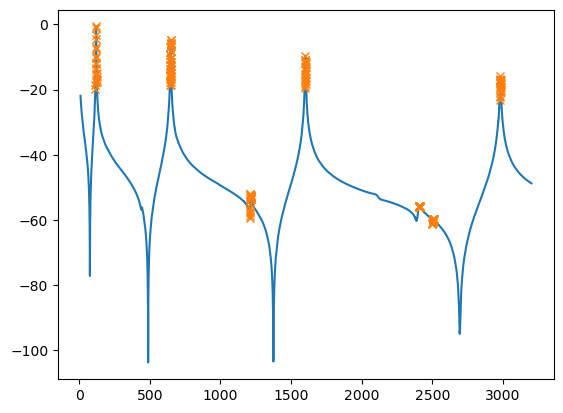

In [45]:

def resonances(data):
    # find the resonances
    peaks = find_peaks(data, prominence=1)[0]
    print(peaks)
    # take the index of the previous and next 10 values of each resonance
    freq = np.linspace(peaks-np.ones(len(peaks))*10, peaks+np.ones(len(peaks))*10, 21).T
    
    # Convert matrix into array
    return freq.flatten().astype(int)
x = resonances(mobility)
plt.plot(freq, mobility)
plt.plot(freq[x], mobility[x], "x")